# Download Datasets

In [6]:
from dataset_downloader import DatasetDownloader
dataset_downloader = DatasetDownloader()

#------------------------------------------------
# Remove the commenting below to download the dataset
#------------------------------------------------

# dataset_downloader.download_datasets("download_paths_2025.yaml")

# Libraries and Hyper Parameters

In [7]:
import matplotlib.pyplot as plt
import yaml
import numpy as np
import librosa

In [8]:
def load_hyper_parameters():
    with open("hyper_parameters.yaml", 'r') as file:
        return yaml.safe_load(file)

In [9]:
hyper_parameters = load_hyper_parameters()

#> Acoustic Features
acoustic_features = hyper_parameters['acoustic_features']
number_of_mels = acoustic_features['number_of_mels']
number_of_frames_to_concatenate = acoustic_features['number_of_frames_to_concatenate']
frame_size_seconds = acoustic_features['frame_size_seconds']
frame_size_samples = acoustic_features['frame_size_samples']
hop_size_seconds = acoustic_features['hop_size_seconds']
hop_size_samples = acoustic_features['hop_size_samples']


#> Dataset Parameters
dataset_paremeters = hyper_parameters['dataset_parameters']
train_data_inclusion_string = dataset_paremeters['train_data_inclusion_string']
test_data_inclusion_string = dataset_paremeters['test_data_inclusion_string']
train_pct = dataset_paremeters['train_pct']
test_pct = dataset_paremeters['test_pct']


#> Training Parameters
training_parameters = hyper_parameters['training_parameters']
batch_size = training_parameters['batch_size']
epochs = training_parameters['epochs']
learning_rate = training_parameters['learning_rate']
shuffle = training_parameters['shuffle']

# Load Dataset

In [10]:
from data_bundler import DataBundler

data_bundler = DataBundler()
clip_lengths, training_data, training_filenames = data_bundler.load_dataset(train_data_inclusion_string, train_pct)
number_of_training_data = len(training_data)


Data Loader Here!
Audio Converter Here!


Processing audio files: 100%|██████████| 1500/1500 [00:13<00:00, 111.96file/s]


Done loading!
Length of dataset: 85766



# Training Autoencoder

In [11]:
!nvidia-smi

Thu May 15 15:11:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| 56%   34C    P8             10W /   75W |    1379MiB /   4096MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

In [17]:
import torch
import torch.nn as nn
import torch.optim as optimizer
from models import BaselineAutoencoder
from torch.utils.data import DataLoader

In [18]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1650
Using device: cuda:0


In [19]:
model = BaselineAutoencoder().to(device)
criterion = nn.MSELoss()
my_optimizer = optimizer.Adam(model.parameters(), lr=learning_rate)
number_of_epochs = epochs

In [20]:
dataset = torch.tensor(training_data, dtype=torch.float32)
input_features = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
len(input_features)

336

In [21]:
import time

training_losses = []
start_time = time.time()

def train_model():
    #> loop through the number of epochs
    for epoch in range(number_of_epochs):
        model.train() #set the model to training mode
        total_loss = 0 #reset the total loss for this epoch

        #> loop through the training data
        for data in input_features:
            input = data.to(device) #move the data to the device (GPU or CPU)
            my_optimizer.zero_grad() #reset the gradients of the optimizer

            #> forward pass
            output = model(input) #pass the data through the model
            loss = criterion(output, input) #calculate the loss by comparing the output to the input data

            #> backward pass
            loss.backward() #compute gradients for all parameters
            my_optimizer.step() #update the model parameters based on the gradients
            total_loss += loss.item() #accumulate the loss for this batch

        average_loss = total_loss / len(input_features)
        training_losses.append(average_loss)

        elapsed_time = time.time() - start_time
        print(f"Epoch [{epoch + 1}/{number_of_epochs}] ({elapsed_time:.2f}s) - Loss: {average_loss:.4f}")

    model.eval()

In [22]:
train_model()

Epoch [1/10] (2.24s) - Loss: 483.1891
Epoch [2/10] (4.21s) - Loss: 40.7317
Epoch [3/10] (6.18s) - Loss: 30.4718
Epoch [4/10] (8.28s) - Loss: 25.6232
Epoch [5/10] (10.21s) - Loss: 22.2695
Epoch [6/10] (12.13s) - Loss: 20.4320
Epoch [7/10] (14.06s) - Loss: 19.6907
Epoch [8/10] (15.98s) - Loss: 18.2548
Epoch [9/10] (17.90s) - Loss: 17.3673
Epoch [10/10] (19.84s) - Loss: 16.6464


In [23]:
# torch.save(model.state_dict(), 'model.pth')

# Training Results

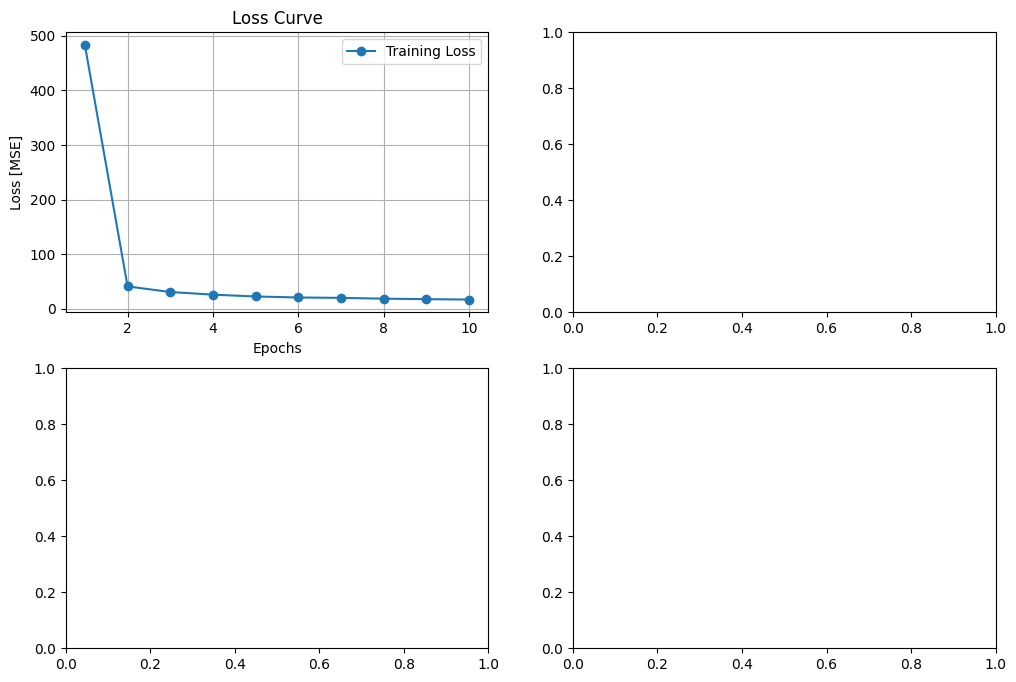

In [50]:
combined_figure, axes = plt.subplots(2,2, figsize=(12, 8))
axes = axes.flatten()

axes[0].plot(range(1, epochs + 1), training_losses, label='Training Loss', marker='o')
axes[0].set_title('Loss Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss [MSE]')
axes[0].legend()
axes[0].grid()
plt.show()

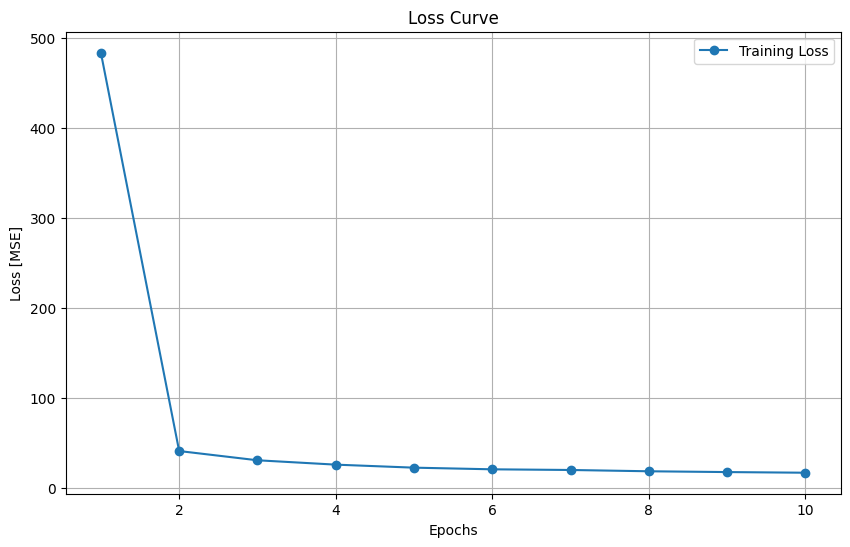

In [29]:
loss_curve_fig, lcf_axes = plt.subplots(figsize=(10, 6))
lcf_axes.plot(range(1, epochs + 1), training_losses, label='Training Loss', marker='o')
lcf_axes.set_title('Loss Curve')
lcf_axes.set_xlabel('Epochs')
lcf_axes.set_ylabel('Loss [MSE]')
lcf_axes.legend()
lcf_axes.grid()
plt.show()

## Load Evaluation Dataset

In [30]:
from data_bundler import DataBundler

data_bundler = DataBundler()
#test_original_mel = data_bundler.load_dataset(test_data_inclusion_string, test_pct, False, False)
clip_lengths, testing_data, testing_filenames = data_bundler.load_dataset(test_data_inclusion_string, test_pct, True, True, "all")
number_of_testing_data = len(testing_data)


Data Loader Here!
Audio Converter Here!


Processing audio files: 100%|██████████| 140/140 [00:01<00:00, 83.89file/s]


Done loading!
Length of dataset: 9161



In [31]:
original_clips = []

start_index = 0

for size in clip_lengths:
    end_index = start_index + size
    original_clips.append(testing_data[start_index:end_index])
    start_index = end_index

In [32]:
import re

status_list = []
pattern = r"_(normal|anomaly)_"

for line in testing_filenames:
    match = re.search(pattern, line)
    if match:
        status_list.append(match.group(1))

# print(len(status_list))
# status_list

## Evaluation

In [33]:
dataset = torch.tensor(testing_data, dtype=torch.float32)
input_features = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [34]:
from torch.nn.functional import mse_loss

mse_list = []
output_features = []


def evaluate_model(input_features, model):
    model.eval()
    total_mse = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in input_features:
            input = data.to(device)
            output = model(input)

            output_features.append(output.cpu().numpy())  # Store the reconstruction for later use

            mse = mse_loss(output, input, reduction='sum').item()
            mse_list.append(mse)
            total_mse += mse
            total_samples += input.numel()
            

    average_mse = total_mse / total_samples
    return average_mse

mse = evaluate_model(input_features, model)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Mean Squared Error on Test Set: 17.7226


In [35]:
output_features = np.vstack(output_features)

In [36]:
print(np.mean((output_features - testing_data)**2))
print(np.mean(np.abs(output_features - testing_data)))

105.10111
7.880938


In [37]:
reconstructed_clips = []
start_index = 0

for size in clip_lengths:
    end_index = start_index + size
    reconstructed_clips.append(output_features[start_index:end_index])
    start_index = end_index

In [ ]:
recon_err_per_clip = []
for i in range(len(reconstructed_clips)):
    item1 = reconstructed_clips[i].reshape(-1)
    item2 = original_clips[i].reshape(-1)
    
    recon_err_per_clip.append(np.mean((item1 - item2)**2))

recon_err_per_clip
print(item1)
print(item2)
print(item1 - item2)
print(np.mean((item1 - item2)**2))
print("\n")
print(recon_err_per_clip)

[-16.410122 -16.649252 -16.459711 ... -57.150387 -57.149563 -57.523033]
[-30.520784 -42.031036 -45.013954 ... -51.338303 -51.554565 -50.87188 ]
[14.110662  25.381784  28.554243  ... -5.812084  -5.5949974 -6.6511536]
126.906075


[np.float32(113.03316), np.float32(57.08624), np.float32(68.56371), np.float32(64.87021), np.float32(118.09521), np.float32(76.9128), np.float32(75.23061), np.float32(142.12967), np.float32(61.970135), np.float32(93.8088), np.float32(117.27544), np.float32(80.369736), np.float32(91.72476), np.float32(93.868675), np.float32(54.881313), np.float32(78.51701), np.float32(71.31905), np.float32(83.69926), np.float32(93.594986), np.float32(114.32096), np.float32(214.05936), np.float32(72.42502), np.float32(75.074394), np.float32(153.94925), np.float32(50.433754), np.float32(49.60436), np.float32(79.05741), np.float32(67.53471), np.float32(187.77393), np.float32(103.14113), np.float32(146.30125), np.float32(109.60609), np.float32(193.00305), np.float32(63.695217), np.f

In [39]:
from scipy.stats import gamma

shape, loc, scale = gamma.fit(recon_err_per_clip)

anomaly_threshold = gamma.ppf(0.9, shape, loc=loc, scale=scale)
anomaly_threshold

np.float64(162.60569411777306)

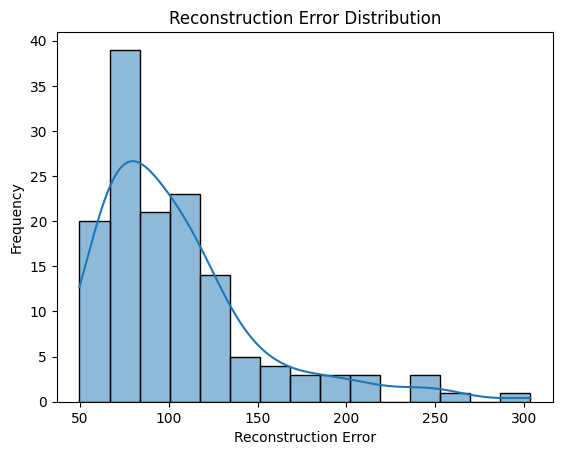

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `recon_err_per_clip` is your data
sns.histplot(recon_err_per_clip, kde=True)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()

162.60569411777306


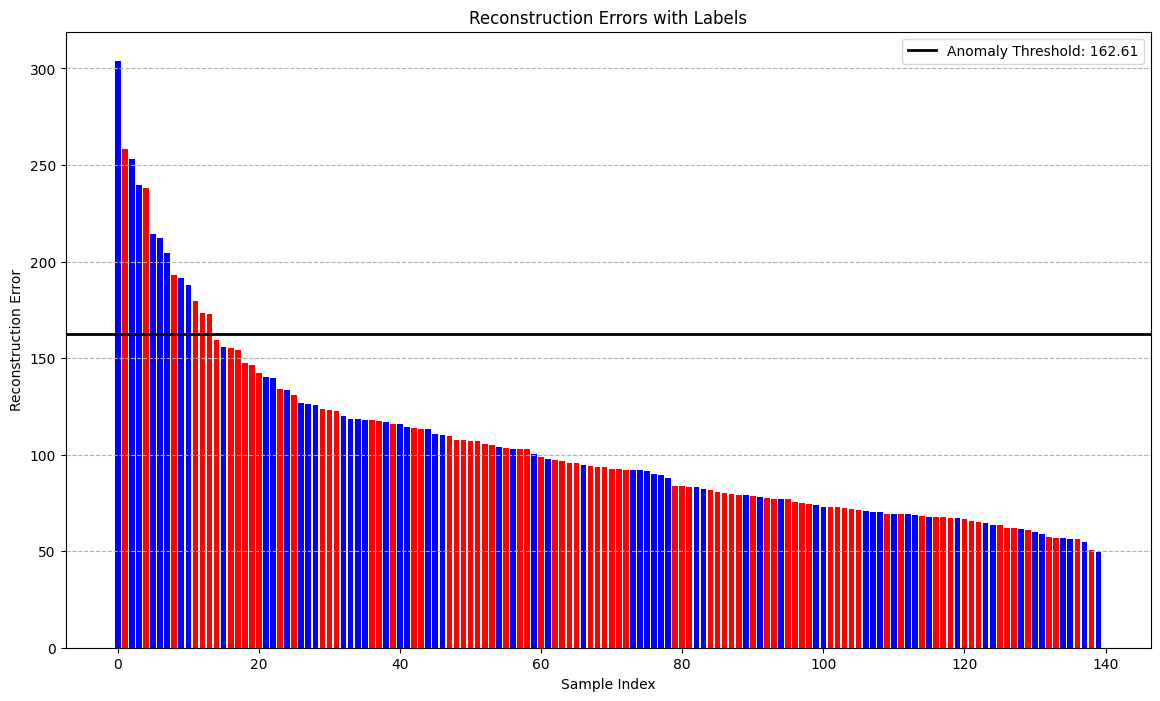

In [41]:
merged = list(zip(status_list, recon_err_per_clip))
# merged

sorted_means = sorted(merged, key=lambda x: x[1], reverse=True)

# Separate the data
labels, values = zip(*sorted_means)  # Unzip the labels and values into two separate lists

# Assign colors based on labels
colors = ['blue' if label == "normal" else 'red' for label in labels]


# Plot the bar chart
plt.figure(figsize=(14, 8))

plt.axhline(y=anomaly_threshold, color='black', linestyle='-', linewidth=2, label=f'Anomaly Threshold: {anomaly_threshold:.2f}')
print(anomaly_threshold)
plt.bar(range(len(values)), values, color=colors)
plt.title('Reconstruction Errors with Labels')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

In [42]:
anomaly_labels = (values > anomaly_threshold).astype(int)

print(f"Anomaly threshold: {anomaly_threshold}")
#print(f"Test errors: {values}")
print(f"Anomalies: {anomaly_labels}")

Anomaly threshold: 162.60569411777306
Anomalies: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


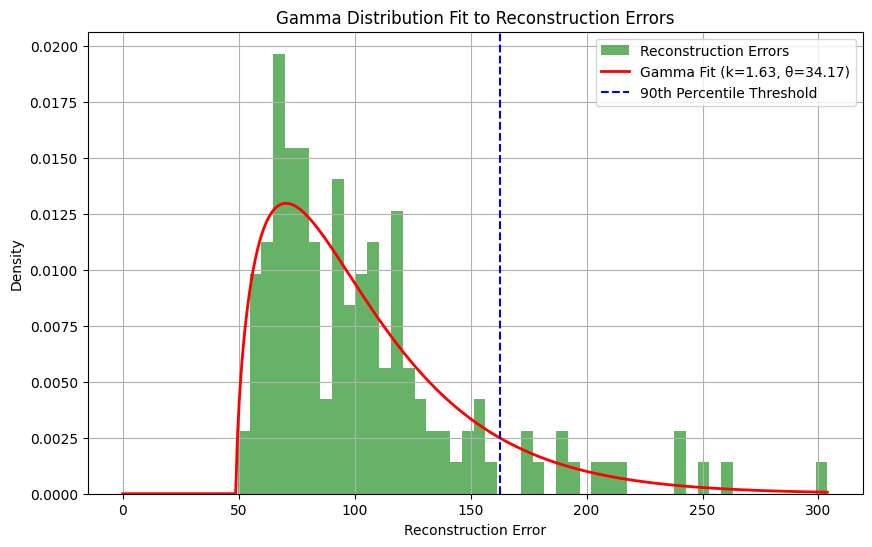

In [43]:
# Generate gamma distribution for visualization
x = np.linspace(0, max(values), 1000)
gamma_pdf = gamma.pdf(x, shape, loc=loc, scale=scale)

# Plot histogram and gamma distribution
plt.figure(figsize=(10, 6))
plt.hist(values, bins=50, density=True, alpha=0.6, color='g', label='Reconstruction Errors')
plt.plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma Fit (k={shape:.2f}, θ={scale:.2f})')
plt.axvline(gamma.ppf(0.90, shape, loc=loc, scale=scale), color='b', linestyle='--', label='90th Percentile Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Gamma Distribution Fit to Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
import re

status_list = []
pattern = r"_(normal|anomaly)_"

for line in testing_filenames:
    match = re.search(pattern, line)
    if match:
        status_list.append(match.group(1))

#print(len(status_list))
#status_list

In [45]:
# Convert to 1 for 'anomaly' and 0 for 'normal'
binary_labels = [1 if label == 'anomaly' else 0 for label in status_list]

print(binary_labels)

[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]


Confusion Matrix:
[[57  3]
 [69 11]]
False Positive Rate (FPR): 0.0500
False Negative Rate (FNR): 0.8625
Recall (Sensitivity): 0.1375
Specificity: 0.9500
Precision: 0.7857
F1-Score: 0.2340
Accuracy: 0.4857


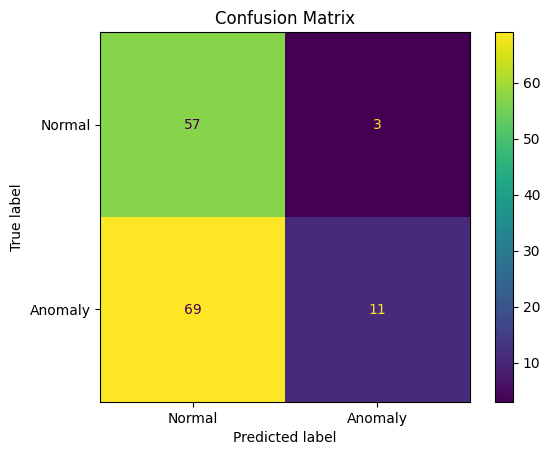

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(binary_labels, anomaly_labels.astype(int))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack values directly

# Calculate metrics
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()


AUC Score: 0.6004 (60%)


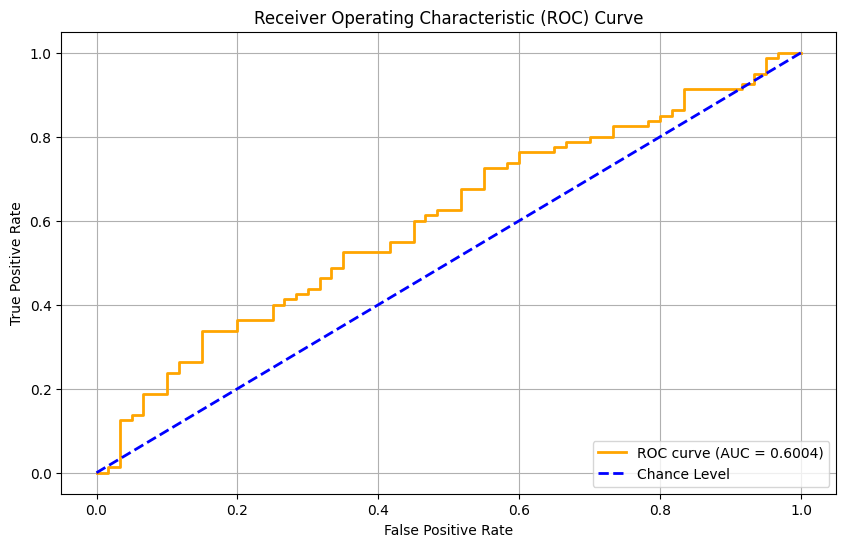

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming `values` contains the predicted scores for each sample (higher = more anomalous)
# `binary_labels` contains the true labels: 0 for Normal, 1 for Anomaly

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(binary_labels, values)  # Use raw scores for ROC computation

# Calculate the Area Under the Curve (AUC)
auc_score = auc(fpr, tpr)
print(f"AUC Score: {auc_score:.4f} ({auc_score*100:.0f}%)")

# Visualize the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Saving Results to PDF

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

hyper_parameters_string = yaml.dump(hyper_parameters, default_flow_style=False)

hyper_parameters_figure, hpf_axes = plt.subplots()
hpf_axes.axis('off')
hpf_axes.text(0.5, 0.5, hyper_parameters_string, fontsize=10, va='center', ha='center', wrap=True)
hpf_axes.set_title("Hyperparameters")

folder_name = "training_results"
os.makedirs(folder_name, exist_ok=True)

existing_files = [f for f in os.listdir(folder_name) if f.endswith(".pdf")]
file_number = len(existing_files) + 1
pdf_filename = os.path.join(folder_name, f"training_results_{file_number}.pdf")

with PdfPages(pdf_filename) as pdf:
    pdf.savefig(hyper_parameters_figure)
    pdf.savefig(loss_curve_fig)
    plt.close('all')